<a href="https://colab.research.google.com/github/Skywalker-666/BMI-Calculator/blob/main/GAN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================
# utils.py — patched for PyTorch 2.6+ checkpoint loading
# =============================
%%writefile utils.py
import os
import random
import numpy as np
import torch

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def save_checkpoint(state: dict, outdir: str, filename: str = "ckpt_last.pt"):
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)
    torch.save(state, path)

def load_checkpoint(path: str, map_location=None):
    """
    PyTorch 2.6 changed torch.load default to weights_only=True, which blocks
    custom classes (e.g., StandardScaler1D) stored inside the checkpoint.
    Force weights_only=False to load trusted local checkpoints.
    """
    try:
        # PyTorch ≥ 2.6: explicitly disable weights_only safe loader
        return torch.load(path, map_location=map_location, weights_only=False)
    except TypeError:
        # PyTorch < 2.6: argument not supported; fall back
        return torch.load(path, map_location=map_location)

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def to_device(batch, device):
    return [x.to(device) if torch.is_tensor(x) else x for x in batch]


Writing utils.py


In [ ]:
# =============================
# File: scalers.py
# =============================
%%writefile scalers.py
import numpy as np

class StandardScaler1D:
    """Channel-wise standardization with invertibility.
    Expects data of shape (..., C) or (N, C) when fitting.
    """
    def __init__(self, eps: float = 1e-8):
        self.mean_ = None
        self.std_ = None
        self.eps = eps

    def fit(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1:
            x = x[:, None]
        self.mean_ = x.mean(axis=0)
        self.std_ = x.std(axis=0) + self.eps
        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x)
        if x.ndim == 1:
            x = x[:, None]
        return (x - self.mean_) / self.std_

    def inverse_transform(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x)
        if x.ndim == 1:
            x = x[:, None]
        return x * self.std_ + self.mean_


Writing scalers.py


In [ ]:
# =============================
# data.py  — clean, Colab-safe
# =============================
%%writefile data.py


import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Optional

# ----- simple per-channel standard scaler (kept here to avoid circular imports) -----
class StandardScaler1D:
    def __init__(self, eps: float = 1e-8):
        self.mean_ = None
        self.std_ = None
        self.eps = eps

    def fit(self, x: np.ndarray):
        x = np.asarray(x, dtype=np.float32).reshape(-1, 1) if x.ndim == 1 else np.asarray(x, dtype=np.float32)
        self.mean_ = x.mean(axis=0)
        self.std_ = x.std(axis=0) + self.eps
        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, dtype=np.float32).reshape(-1, 1) if x.ndim == 1 else np.asarray(x, dtype=np.float32)
        return (x - self.mean_) / self.std_

    def inverse_transform(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, dtype=np.float32).reshape(-1, 1) if x.ndim == 1 else np.asarray(x, dtype=np.float32)
        return x * self.std_ + self.mean_


# ----- dataset -----
class LoadPriceDataset(Dataset):
    """
    Returns tuples: (hist[T_h, 2], target[T_f, 2], cal_hist[T_h, F], cal_fut[T_f, F])
    where F is 4 if use_calendar, else 0. No None objects are returned.
    """
    def __init__(
        self,
        df: pd.DataFrame,
        time_col: str,
        load_col: str,
        price_col: str,
        hist_len: int = 48,
        seq_len: int = 48,
        use_calendar: bool = False,
        load_scaler: Optional[StandardScaler1D] = None,
        price_scaler: Optional[StandardScaler1D] = None,
    ):
        self.df = df.sort_values(time_col).reset_index(drop=True)
        self.time_col = time_col
        self.load_col = load_col
        self.price_col = price_col
        self.hist_len = hist_len
        self.seq_len = seq_len
        self.use_calendar = use_calendar

        # Arrays
        self.load = self.df[load_col].values.astype(np.float32)
        self.price = self.df[price_col].values.astype(np.float32)

        # Scalers (shared between train/val)
        self.load_scaler = load_scaler or StandardScaler1D().fit(self.load)
        self.price_scaler = price_scaler or StandardScaler1D().fit(self.price)

        self.load_z = self.load_scaler.transform(self.load).astype(np.float32).squeeze()
        self.price_z = self.price_scaler.transform(self.price).astype(np.float32).squeeze()

        # Calendar features (sin/cos of hour-of-day and day-of-week)
        if self.use_calendar:
            t = pd.to_datetime(self.df[time_col])
            # infer samples per day from spacing (fallback: 48)
            if len(t) >= 2:
                delta_sec = max(1.0, (t.iloc[1] - t.iloc[0]).total_seconds())
                spd = int(round(86400.0 / delta_sec))
            else:
                spd = 48
            if spd < 4:
                spd = 24
            idx = np.arange(len(t)) % spd
            hod_sin = np.sin(2 * np.pi * idx / spd)
            hod_cos = np.cos(2 * np.pi * idx / spd)
            dow = t.dt.weekday.to_numpy()
            dow_sin = np.sin(2 * np.pi * dow / 7)
            dow_cos = np.cos(2 * np.pi * dow / 7)
            self.cal_feats = np.stack([hod_sin, hod_cos, dow_sin, dow_cos], axis=1).astype(np.float32)
        else:
            self.cal_feats = None

        # number of windows
        self.length = max(0, len(self.df) - (self.hist_len + self.seq_len) + 1)

    def __len__(self):
        return self.length

    def __getitem__(self, idx: int):
        s = idx
        h0, h1 = s, s + self.hist_len
        t0, t1 = h1, h1 + self.seq_len

        # history (H, 2): [load, price]
        hist = np.stack([self.load_z[h0:h1], self.price_z[h0:h1]], axis=1).astype(np.float32)
        # target  (T, 2)
        target = np.stack([self.load_z[t0:t1], self.price_z[t0:t1]], axis=1).astype(np.float32)

        if self.use_calendar and self.cal_feats is not None:
            cal_hist = self.cal_feats[h0:h1]  # (H, 4)
            cal_fut = self.cal_feats[t0:t1]   # (T, 4)
        else:
            # Empty feature tensors with correct time lengths, zero feature dims.
            cal_hist = np.empty((self.hist_len, 0), dtype=np.float32)
            cal_fut  = np.empty((self.seq_len, 0), dtype=np.float32)

        return (
            torch.from_numpy(hist),            # (H, 2)
            torch.from_numpy(target),          # (T, 2)
            torch.from_numpy(cal_hist),        # (H, F)  F∈{0,4}
            torch.from_numpy(cal_fut),         # (T, F)
        )


# ----- helpers -----
def _maybe_build_timestamp(
    df: pd.DataFrame,
    time_col: str,
    date_col: Optional[str],
    period_col: Optional[str],
    periods_per_day: int,
):
    """
    If time_col exists -> return df, time_col.
    Else if date_col & period_col exist -> build a timestamp:
        timestamp = to_datetime(DATE) + (PERIOD-1) * (1440/periods_per_day) minutes
    Returns (df_with_timestamp, resolved_time_col).
    """
    if time_col in df.columns:
        return df, time_col

    if date_col and period_col and (date_col in df.columns) and (period_col in df.columns):
        base = pd.to_datetime(df[date_col])
        step_minutes = int(round(1440 / max(1, periods_per_day)))
        # PERIOD is 1-based in your file
        offset = pd.to_timedelta((df[period_col].astype(int) - 1) * step_minutes, unit="m")
        df = df.copy()
        df["__timestamp"] = base + offset
        return df, "__timestamp"

    raise KeyError(
        f"time_col '{time_col}' not found and could not derive from date_col/period_col."
    )


# ----- main loader factory -----
def make_loaders(
    csv_path: str,
    time_col: str,
    load_col: str,
    price_col: str,
    hist_len: int,
    seq_len: int,
    batch: int,
    val_ratio: float = 0.1,
    use_calendar: bool = False,
    num_workers: int = 0,
    date_col: Optional[str] = None,
    period_col: Optional[str] = None,
    periods_per_day: int = 48,
):
    df = pd.read_csv(csv_path)

    # Build a timestamp when needed
    df, resolved_time = _maybe_build_timestamp(df, time_col, date_col, period_col, periods_per_day)

    # Keep only needed cols and normalize the name 'timestamp'
    df = df[[resolved_time, load_col, price_col]].dropna().copy()
    df = df.rename(columns={resolved_time: "timestamp"})

    # time-based split
    n = len(df)
    n_val = int(n * val_ratio)
    df_tr = df.iloc[: n - n_val].copy()
    df_va = df.iloc[n - n_val :].copy()

    # shared scalers
    load_scaler = StandardScaler1D().fit(df_tr[load_col].values.astype(np.float32))
    price_scaler = StandardScaler1D().fit(df_tr[price_col].values.astype(np.float32))

    dtr = LoadPriceDataset(
        df_tr, "timestamp", load_col, price_col,
        hist_len, seq_len, use_calendar, load_scaler, price_scaler
    )
    dva = LoadPriceDataset(
        df_va, "timestamp", load_col, price_col,
        hist_len, seq_len, use_calendar, load_scaler, price_scaler
    )

    tr_loader = DataLoader(
        dtr, batch_size=batch, shuffle=True, drop_last=True,
        num_workers=num_workers, pin_memory=False  # False is safer on CPU/Colab
    )
    va_loader = DataLoader(
        dva, batch_size=batch, shuffle=False, drop_last=False,
        num_workers=num_workers, pin_memory=False
    )

    meta = {
        "load_scaler": load_scaler,
        "price_scaler": price_scaler,
        "n_train_rows": len(df_tr),
        "n_val_rows": len(df_va),
    }
    return tr_loader, va_loader, meta


Writing data.py


In [ ]:
# =============================
# models.py — residual generator (predict Δy), channel-aware
# =============================
%%writefile models.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class TConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, d=1, p=None):
        super().__init__()
        pad = p if p is not None else (k - 1) * d // 2
        self.conv = nn.Conv1d(c_in, c_out, kernel_size=k, dilation=d, padding=pad)
        self.bn = nn.BatchNorm1d(c_out)
        self.act = nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResTCN(nn.Module):
    def __init__(self, c_in, channels=(64, 64, 64), k=3):
        super().__init__()
        layers, last = [], c_in
        for c in channels:
            layers += [TConvBlock(last, c, k=k)]
            last = c
        self.net = nn.Sequential(*layers)
        self.out_channels = last
    def forward(self, x):
        return self.net(x)

class Generator(nn.Module):
    """
    Predicts Δy (residual) given history & noise.
      z : [B, z_dim]
      h : [B, 2, H]      (standardized)
      ch: [B, 4, H] or empty
      cf: [B, 4, T] or empty (unused here, kept for API)
    Returns residual Δy: [B, 2, T] (standardized units)
    """
    def __init__(self, z_dim=64, hist_len=48, seq_len=48, use_calendar=False):
        super().__init__()
        self.z_dim, self.hist_len, self.seq_len = z_dim, hist_len, seq_len
        self.use_calendar = use_calendar

        cond_ch = 2 + (4 if use_calendar else 0)
        self.enc = ResTCN(c_in=cond_ch, channels=(64, 128, 128))
        self.fc_z = nn.Linear(z_dim, 128)
        self.fc_hist = nn.Linear(self.enc.out_channels, 128)
        self.fc = nn.Linear(256, 128)

        self.dec = nn.Sequential(
            nn.ConvTranspose1d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 2, kernel_size=1)  # 2 channels residual
        )
        target_len = 2 * self.hist_len
        self.proj_len = nn.Linear(target_len, self.seq_len)

        # Scale residuals conservatively; learnable for flexibility
        self.res_scale = nn.Parameter(torch.tensor(0.5))

    def forward(self, z, h, ch=None, cf=None):
        if self.use_calendar and ch is not None and ch.size(1) > 0:
            x = torch.cat([h, ch], dim=1)     # [B, 2(+4), H]
        else:
            x = h

        feat = self.enc(x).mean(dim=-1)       # [B, C]
        hz = torch.relu(self.fc_hist(feat))   # [B, 128]
        zz = torch.relu(self.fc_z(z))         # [B, 128]
        fused = torch.relu(self.fc(torch.cat([hz, zz], dim=1)))  # [B, 128]

        dec_in = fused[:, :, None].repeat(1, 1, self.hist_len)   # [B,128,H]
        out = self.dec(dec_in)                                   # [B,2,~2H]

        target_len = 2 * self.hist_len
        if out.size(-1) < target_len:
            out = F.pad(out, (0, target_len - out.size(-1)))
        elif out.size(-1) > target_len:
            out = out[..., :target_len]

        B, C, L = out.shape
        res = out.reshape(B * C, L)
        res = self.proj_len(res)                                 # (B*2, T)
        res = res.reshape(B, C, self.seq_len)                    # [B,2,T]

        # Bound residuals with tanh and learnable scale
        return torch.tanh(res) * self.res_scale                  # Δy

class Critic(nn.Module):
    """
    WGAN critic; conditions on history by concatenation along channels.
      y : [B, 2, T]  (the FINAL series passed to critic, i.e., baseline + residual)
      h : [B, 2, H]
      ch: [B, 4, H] or empty
      cf: [B, 4, T] or empty
    """
    def __init__(self, hist_len=48, seq_len=48, use_calendar=False):
        super().__init__()
        self.use_calendar = use_calendar
        in_ch_hist = 2 + (4 if use_calendar else 0)
        in_ch_fut  = 2 + (4 if use_calendar else 0)
        self.enc_h = ResTCN(c_in=in_ch_hist, channels=(64, 128))
        self.enc_y = ResTCN(c_in=in_ch_fut,  channels=(64, 128))
        self.fc = nn.Sequential(
            nn.Linear(self.enc_h.out_channels + self.enc_y.out_channels, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )
    def forward(self, y, h, ch=None, cf=None):
        h_in = torch.cat([h, ch], dim=1) if (self.use_calendar and ch is not None and ch.size(1) > 0) else h
        y_in = torch.cat([y, cf], dim=1) if (self.use_calendar and cf is not None and cf.size(1) > 0) else y
        fh = self.enc_h(h_in).mean(dim=-1)
        fy = self.enc_y(y_in).mean(dim=-1)
        return self.fc(torch.cat([fh, fy], dim=1))


Writing models.py


In [ ]:
# =============================
# File: losses.py
# =============================
%%writefile losses.py

import torch
from torch import autograd


def gradient_penalty(critic, real, fake, h, ch, cf, device):
    B = real.size(0)
    alpha = torch.rand(B, 1, 1, device=device)
    inter = real * alpha + fake * (1 - alpha)
    inter.requires_grad_(True)
    d_inter = critic(inter, h, ch, cf)
    grad = autograd.grad(
        outputs=d_inter,
        inputs=inter,
        grad_outputs=torch.ones_like(d_inter),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    grad = grad.reshape(B, -1)
    gp = ((grad.norm(2, dim=1) - 1) ** 2).mean()
    return gp


Writing losses.py


In [ ]:
# =============================
# train.py — residual learning + warmup + strong L1
# =============================
%%writefile train.py
import argparse
import os
import numpy as np
import torch
import torch.optim as optim
from tqdm import tqdm

from data import make_loaders
from models import Generator, Critic
from losses import gradient_penalty
from utils import seed_everything, save_checkpoint, rmse, mae


def train(args):
    seed_everything(args.seed)
    device = torch.device("cuda" if torch.cuda.is_available() and not args.cpu else "cpu")

    tr_loader, va_loader, meta = make_loaders(
        csv_path=args.csv_path,
        time_col=args.time_col,
        load_col=args.load_col,
        price_col=args.price_col,
        hist_len=args.hist_len,
        seq_len=args.seq_len,
        batch=args.batch,
        val_ratio=args.val_ratio,
        use_calendar=args.use_calendar,
        num_workers=args.num_workers,
        date_col=args.date_col,
        period_col=args.period_col,
        periods_per_day=args.periods_per_day
    )

    G = Generator(z_dim=args.z_dim, hist_len=args.hist_len, seq_len=args.seq_len,
                  use_calendar=args.use_calendar).to(device)
    C = Critic(hist_len=args.hist_len, seq_len=args.seq_len,
               use_calendar=args.use_calendar).to(device)

    opt_G = optim.Adam(G.parameters(), lr=args.lr_g, betas=(0.5, 0.9))
    opt_C = optim.Adam(C.parameters(), lr=args.lr_c, betas=(0.5, 0.9))

    best_val = float('inf')
    os.makedirs(args.outdir, exist_ok=True)

    for epoch in range(1, args.epochs + 1):
        C.train(); G.train()
        pbar = tqdm(tr_loader, desc=f"Epoch {epoch}/{args.epochs}")
        for i, batch in enumerate(pbar):
            # batch: hist(B,H,2) target(B,T,2) cal_hist(B,H,F) cal_fut(B,T,F)
            h, y_real, ch, cf = batch
            h = h.permute(0, 2, 1).to(device)         # [B,2,H]
            y_real = y_real.permute(0, 2, 1).to(device)  # [B,2,T]
            ch = ch.permute(0, 2, 1).to(device) if ch is not None else None  # [B,F,H]
            cf = cf.permute(0, 2, 1).to(device) if cf is not None else None  # [B,F,T]

            # -------- baseline: yesterday's pattern (last H=48 from history) --------
            base = h[:, :, -args.seq_len:]            # [B,2,T] in standardized units

            # ===== Critic (skip during warmup) =====
            do_adv = epoch > args.warmup_l1
            if do_adv:
                for _ in range(args.c_iters):
                    z = torch.randn(h.size(0), args.z_dim, device=device)
                    with torch.no_grad():
                        res_det = G(z, h, ch, cf)     # Δy
                        y_fake_det = base + res_det   # final sample
                    C_real = C(y_real, h, ch, cf).mean()
                    C_fake = C(y_fake_det, h, ch, cf).mean()
                    gp = gradient_penalty(C, y_real, y_fake_det, h, ch, cf, device)
                    loss_C = -(C_real - C_fake) + args.gp_lambda * gp
                    opt_C.zero_grad(set_to_none=True)
                    loss_C.backward()
                    opt_C.step()

            # ===== Generator =====
            z = torch.randn(h.size(0), args.z_dim, device=device)
            res = G(z, h, ch, cf)                     # Δy
            y_fake = base + res                       # final

            # Strong supervised term (pulls to real)
            l1 = (y_fake - y_real).abs().mean()

            if do_adv:
                adv_loss = -C(y_fake, h, ch, cf).mean()
                G_loss = args.adv_weight * adv_loss + args.lambda_l1 * l1
            else:
                # warmup: pure L1 for stability/proximity
                G_loss = args.lambda_l1 * l1

            opt_G.zero_grad(set_to_none=True)
            G_loss.backward()
            opt_G.step()

        # ===== Validation =====
        G.eval()
        y_true_all, y_pred_all = [], []
        with torch.no_grad():
            for batch in va_loader:
                h, y_real, ch, cf = batch
                h = h.permute(0, 2, 1).to(device)
                y_real = y_real.permute(0, 2, 1).to(device)
                ch = ch.permute(0, 2, 1).to(device) if ch is not None else None
                cf = cf.permute(0, 2, 1).to(device) if cf is not None else None

                base = h[:, :, -args.seq_len:]        # [B,2,T]
                B = h.size(0)
                samples = []
                for _ in range(args.val_samples):
                    z = torch.randn(B, args.z_dim, device=device)
                    res = G(z, h, ch, cf)
                    samples.append((base + res).unsqueeze(0))
                S = torch.cat(samples, dim=0)         # [S,B,2,T]
                y_med = S.median(dim=0).values        # [B,2,T]

                y_true_all.append(y_real.cpu().numpy())
                y_pred_all.append(y_med.cpu().numpy())

        y_true = np.concatenate(y_true_all, axis=0)
        y_pred = np.concatenate(y_pred_all, axis=0)

        rmse_load = rmse(y_true[:, 0, :], y_pred[:, 0, :])
        rmse_price = rmse(y_true[:, 1, :], y_pred[:, 1, :])
        mae_load = mae(y_true[:, 0, :], y_pred[:, 0, :])
        mae_price = mae(y_true[:, 1, :], y_pred[:, 1, :])
        val_score = (rmse_load + rmse_price) / 2.0

        print(f"Val — RMSE load: {rmse_load:.4f}, RMSE price: {rmse_price:.4f} | "
              f"MAE load: {mae_load:.4f}, MAE price: {mae_price:.4f}")

        # Save last and best
        save_checkpoint({
            "G": G.state_dict(),
            "C": C.state_dict(),
            "opt_G": opt_G.state_dict(),
            "opt_C": opt_C.state_dict(),
            "args": vars(args),
            "meta": meta
        }, args.outdir, "ckpt_last.pt")

        if val_score < best_val:
            best_val = val_score
            save_checkpoint({
                "G": G.state_dict(),
                "C": C.state_dict(),
                "opt_G": opt_G.state_dict(),
                "opt_C": opt_C.state_dict(),
                "args": vars(args),
                "meta": meta,
                "best_val": best_val
            }, args.outdir, "ckpt_best.pt")
            print(f"Saved new best with score {best_val:.4f}")


if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument('--csv_path', type=str, required=True)
    # Either provide time_col, or provide (date_col, period_col, periods_per_day)
    ap.add_argument('--time_col', type=str, default='timestamp')
    ap.add_argument('--date_col', type=str, default=None)
    ap.add_argument('--period_col', type=str, default=None)
    ap.add_argument('--periods_per_day', type=int, default=48)

    ap.add_argument('--load_col', type=str, default='LOAD')
    ap.add_argument('--price_col', type=str, default='USEP')  # your CSV
    ap.add_argument('--hist_len', type=int, default=48)
    ap.add_argument('--seq_len', type=int, default=48)
    ap.add_argument('--batch', type=int, default=128)
    ap.add_argument('--epochs', type=int, default=50)
    ap.add_argument('--val_ratio', type=float, default=0.1)
    ap.add_argument('--z_dim', type=int, default=64)
    ap.add_argument('--lr_g', type=float, default=2e-4)
    ap.add_argument('--lr_c', type=float, default=2e-4)
    ap.add_argument('--c_iters', type=int, default=5)
    ap.add_argument('--gp_lambda', type=float, default=10.0)
    ap.add_argument('--val_samples', type=int, default=30)
    ap.add_argument('--lambda_l1', type=float, default=20.0)   # ↑ strong proximity
    ap.add_argument('--adv_weight', type=float, default=1.0)
    ap.add_argument('--warmup_l1', type=int, default=3)        # epochs of pure L1
    ap.add_argument('--cpu', action='store_true')
    ap.add_argument('--seed', type=int, default=42)
    ap.add_argument('--use_calendar', action='store_true')
    ap.add_argument('--num_workers', type=int, default=0)
    ap.add_argument('--outdir', type=str, default='checkpoints')
    args = ap.parse_args()
    train(args)


Writing train.py


In [ ]:
# =============================
# File: sample.py  (validation evaluator)
# =============================
%%writefile sample.py
import argparse
import numpy as np
import torch
import pandas as pd

from data import make_loaders
from models import Generator            # <- fix: models, not model
from utils import load_checkpoint, rmse, mae


def evaluate(args):
    device = torch.device("cuda" if torch.cuda.is_available() and not args.cpu else "cpu")

    # ---- Load checkpoint and pull training args to avoid shape mismatches
    ckpt = load_checkpoint(args.checkpoint, map_location=device)
    targs = ckpt["args"]
    z_dim       = targs.get("z_dim", args.z_dim)
    hist_len    = targs.get("hist_len", args.hist_len)
    seq_len     = targs.get("seq_len", args.seq_len)
    use_calendar= targs.get("use_calendar", args.use_calendar)
    # column names
    load_col    = targs.get("load_col", args.load_col)
    price_col   = targs.get("price_col", args.price_col)
    # time resolution
    time_col    = targs.get("time_col", args.time_col)
    date_col    = targs.get("date_col", args.date_col)
    period_col  = targs.get("period_col", args.period_col)
    ppd         = targs.get("periods_per_day", args.periods_per_day)
    # loader hyperparams
    batch       = targs.get("batch", args.batch)
    val_ratio   = targs.get("val_ratio", args.val_ratio)
    num_workers = targs.get("num_workers", args.num_workers)

    # ---- Build ONLY the validation loader (same split logic as training)
    _, va_loader, meta = make_loaders(
        csv_path=args.csv_path,
        time_col=time_col,
        load_col=load_col,
        price_col=price_col,
        hist_len=hist_len,
        seq_len=seq_len,
        batch=batch,
        val_ratio=val_ratio,
        use_calendar=use_calendar,
        num_workers=num_workers,
        date_col=date_col,
        period_col=period_col,
        periods_per_day=ppd
    )

    # ---- Model
    G = Generator(z_dim=z_dim, hist_len=hist_len, seq_len=seq_len, use_calendar=use_calendar).to(device)
    G.load_state_dict(ckpt["G"])
    G.eval()

    # Optional affine calibration (standardized space) if present
    calib = ckpt.get("meta", {}).get("affine_calib", None)
    def apply_calib(y):  # y: [B,2,T] standardized
        if calib is None:
            return y
        aL, bL = calib["load"]["a"],  calib["load"]["b"]
        aP, bP = calib["price"]["a"], calib["price"]["b"]
        y2 = y.clone()
        y2[:,0,:] = y2[:,0,:]*aL + bL
        y2[:,1,:] = y2[:,1,:]*aP + bP
        return y2

    y_true_all, y_point_all = [], []

    # ---- Evaluate (median of samples) using residual + baseline
    with torch.no_grad():
        for batch in va_loader:
            h, y_real, ch, cf = batch                     # h:[B,H,2], y_real:[B,T,2]
            h  = h.permute(0, 2, 1).to(device)            # [B,2,H]
            y_real = y_real.permute(0, 2, 1).to(device)   # [B,2,T]
            ch = ch.permute(0, 2, 1).to(device) if (use_calendar and ch is not None) else None  # [B,4,H]
            cf = cf.permute(0, 2, 1).to(device) if (use_calendar and cf is not None) else None  # [B,4,T]

            base = h[:, :, -seq_len:]                     # previous 48, standardized

            B = h.size(0)
            samples = []
            for _ in range(args.n_samples):
                z = torch.randn(B, z_dim, device=device)
                res = G(z, h, ch, cf)                     # Δy
                y_fake = base + res                       # final standardized
                y_fake = apply_calib(y_fake)              # optional affine fix
                samples.append(y_fake.unsqueeze(0))
            S = torch.cat(samples, dim=0)                 # [S,B,2,T]
            y_med = S.median(dim=0).values                # [B,2,T]

            y_true_all.append(y_real.cpu().numpy())
            y_point_all.append(y_med.cpu().numpy())

    y_true = np.concatenate(y_true_all, axis=0)   # standardized
    y_pred = np.concatenate(y_point_all, axis=0)

    print("Validation metrics (standardized space):")
    print(f"RMSE LOAD : {rmse(y_true[:,0,:], y_pred[:,0,:]):.4f}")
    print(f"RMSE USEP : {rmse(y_true[:,1,:], y_pred[:,1,:]):.4f}")
    print(f"MAE  LOAD : {mae(y_true[:,0,:], y_pred[:,0,:]):.4f}")
    print(f"MAE  USEP : {mae(y_true[:,1,:], y_pred[:,1,:]):.4f}")


if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument('--checkpoint', type=str, required=True)
    ap.add_argument('--csv_path', type=str, required=True)

    # Either provide time_col OR (date_col, period_col, periods_per_day)
    ap.add_argument('--time_col', type=str, default='timestamp')
    ap.add_argument('--date_col', type=str, default=None)
    ap.add_argument('--period_col', type=str, default=None)
    ap.add_argument('--periods_per_day', type=int, default=48)

    ap.add_argument('--load_col', type=str, default='LOAD')
    ap.add_argument('--price_col', type=str, default='USEP')   # <- your CSV uses USEP
    ap.add_argument('--hist_len', type=int, default=48)
    ap.add_argument('--seq_len', type=int, default=48)
    ap.add_argument('--batch', type=int, default=128)
    ap.add_argument('--val_ratio', type=float, default=0.1)
    ap.add_argument('--z_dim', type=int, default=64)
    ap.add_argument('--n_samples', type=int, default=100)
    ap.add_argument('--cpu', action='store_true')
    ap.add_argument('--use_calendar', action='store_true')
    ap.add_argument('--num_workers', type=int, default=0)

    args = ap.parse_args()
    evaluate(args)


Writing sample.py


In [ ]:
!python train.py \
  --csv_path Real_usep_load_pv_rp.csv \
  --date_col DATE --period_col PERIOD --periods_per_day 48 \
  --load_col LOAD --price_col USEP \
  --hist_len 48 --seq_len 48 \
  --epochs 50 --batch 128 \
  --z_dim 64 \
  --lr_g 2e-4 --lr_c 2e-4 --c_iters 5 --gp_lambda 10 \
  --val_ratio 0.1 \
  --lambda_l1 20 --warmup_l1 3 \
  --use_calendar \
  --outdir checkpoints_residual

In [ ]:
# If you trained to checkpoints_residual and ran calibration:
!python sample.py \
  --checkpoint checkpoints_residual/ckpt_best_calib.pt \
  --csv_path Real_usep_load_pv_rp.csv \
  --date_col DATE --period_col PERIOD --periods_per_day 48 \
  --load_col LOAD --price_col USEP \
  --hist_len 48 --seq_len 48 \
  --n_samples 100 \
  --use_calendar


Validation metrics (standardized space):
RMSE LOAD : 0.8970
RMSE USEP : 0.2971
MAE  LOAD : 0.6813
MAE  USEP : 0.1743


In [ ]:
# =============================
# calibrate_affine.py
# =============================
%%writefile calibrate_affine.py
import argparse, os, torch, numpy as np
from utils import load_checkpoint, save_checkpoint, seed_everything
from data import make_loaders
from models import Generator

def fit_affine(y_pred, y_true):
    # Solve y_true ≈ a * y_pred + b (least squares), vectorized over all horizons
    x = y_pred.reshape(-1, 1)             # (N,1)
    y = y_true.reshape(-1, 1)             # (N,1)
    X = np.concatenate([x, np.ones_like(x)], axis=1)  # [x, 1]
    # a,b = (X^T X)^-1 X^T y
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    a = float(beta[0,0]); b = float(beta[1,0])
    return a, b

def main(args):
    seed_everything(42)
    device = torch.device("cuda" if torch.cuda.is_available() and not args.cpu else "cpu")

    ckpt = load_checkpoint(args.checkpoint, map_location=device)
    targs = ckpt["args"]
    hist_len = targs["hist_len"]; seq_len = targs["seq_len"]; use_calendar = targs.get("use_calendar", False)

    # data loaders with same args used in training
    _, va_loader, meta = make_loaders(
        csv_path=args.csv_path,
        time_col=targs.get("time_col"),
        load_col=targs["load_col"],
        price_col=targs["price_col"],
        hist_len=hist_len,
        seq_len=seq_len,
        batch=targs.get("batch", 128),
        val_ratio=targs.get("val_ratio", 0.1),
        use_calendar=use_calendar,
        num_workers=targs.get("num_workers", 0),
        date_col=targs.get("date_col"),
        period_col=targs.get("period_col"),
        periods_per_day=targs.get("periods_per_day", 48),
    )

    G = Generator(z_dim=targs["z_dim"], hist_len=hist_len, seq_len=seq_len,
                  use_calendar=use_calendar).to(device)
    G.load_state_dict(ckpt["G"]); G.eval()

    preds = []; trues = []
    with torch.no_grad():
        for h, y_real, ch, cf in va_loader:
            h  = h.permute(0,2,1).to(device)         # [B,2,H]
            y  = y_real.permute(0,2,1).to(device)    # [B,2,T]
            ch = ch.permute(0,2,1).to(device) if ch is not None else None
            cf = cf.permute(0,2,1).to(device) if cf is not None else None

            base = h[:, :, -seq_len:]
            z = torch.zeros(h.size(0), targs["z_dim"], device=device)  # deterministic mean-ish
            res = G(z, h, ch, cf)
            y_hat = base + res  # [B,2,T]
            preds.append(y_hat.cpu().numpy()); trues.append(y.cpu().numpy())

    y_pred = np.concatenate(preds, axis=0)   # [N,2,T] standardized
    y_true = np.concatenate(trues, axis=0)   # [N,2,T]

    # fit per-channel affine
    a_load, b_load   = fit_affine(y_pred[:,0,:], y_true[:,0,:])
    a_price, b_price = fit_affine(y_pred[:,1,:], y_true[:,1,:])

    print(f"[calibrate] LOAD:  a={a_load:.4f}, b={b_load:.4f}")
    print(f"[calibrate] USEP:  a={a_price:.4f}, b={b_price:.4f}")

    # stash into checkpoint meta
    meta = ckpt.get("meta", {})
    meta["affine_calib"] = {
        "load":  {"a": a_load,  "b": b_load},
        "price": {"a": a_price, "b": b_price}
    }
    ckpt["meta"] = meta

    outdir = os.path.dirname(args.checkpoint)
    save_checkpoint(ckpt, outdir, "ckpt_best_calib.pt")
    print(f"Saved calibrated checkpoint to {os.path.join(outdir,'ckpt_best_calib.pt')}")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--checkpoint", type=str, required=True)
    ap.add_argument("--csv_path", type=str, required=True)
    ap.add_argument("--cpu", action="store_true")
    args = ap.parse_args()
    main(args)


Overwriting calibrate_affine.py


In [ ]:
# =============================
# forecast.py — residual+baseline with optional affine calibration
# =============================
%%writefile forecast.py
import argparse, numpy as np, pandas as pd, torch, os
from utils import load_checkpoint
from models import Generator

def _resolve_timestamp(df, time_col, date_col, period_col, periods_per_day):
    if time_col and (time_col in df.columns): return df, time_col
    if (date_col in df.columns) and (period_col in df.columns):
        base = pd.to_datetime(df[date_col], errors="coerce")
        step = int(round(1440 / max(1, periods_per_day)))
        off  = pd.to_timedelta((df[period_col].astype(int) - 1) * step, unit="m")
        df = df.copy(); df["__timestamp"] = base + off
        return df, "__timestamp"
    raise KeyError("Provide --time_col OR (--date_col and --period_col).")

def _parse_date(s):
    ts = pd.to_datetime(s, errors="coerce");
    if pd.isna(ts): ts = pd.to_datetime(s, errors="coerce", dayfirst=True)
    if pd.isna(ts): raise ValueError(f"Bad target_date {s}")
    return pd.Timestamp(ts.normalize())

def _hist_and_day(df, tcol, d, H, T, ppd):
    df = df.sort_values(tcol).reset_index(drop=True)
    ts = pd.to_datetime(df[tcol]); D = pd.Timestamp(d.normalize())
    avail = pd.Index(ts.dt.normalize().unique())
    if D not in avail:
        bef = avail[avail < D]; aft = avail[avail > D]
        D = (bef.max() if len(bef) else aft.min())
        print(f"[forecast] fallback to {D.date()}")
    m = ts.dt.normalize() == D; idx = np.where(m)[0]
    if len(idx)==0: raise ValueError("no rows for chosen day")
    s = idx[0];
    if s < H:   raise ValueError("not enough history")
    hist = df.iloc[s-H:s].copy(); day = df.iloc[s:s+T].copy()
    if len(day) < T: raise ValueError("need full 48")
    return hist, day, D.date()

def main(a):
    dev = torch.device("cuda" if torch.cuda.is_available() and not a.cpu else "cpu")
    ck  = load_checkpoint(a.checkpoint, map_location=dev)
    ta  = ck["args"]; H=ta["hist_len"]; T=ta["seq_len"]; use_cal=ta.get("use_calendar", False)
    G   = Generator(z_dim=ta["z_dim"], hist_len=H, seq_len=T, use_calendar=use_cal).to(dev)
    G.load_state_dict(ck["G"]); G.eval()

    df = pd.read_csv(a.csv_path)
    df, tcol = _resolve_timestamp(df, a.time_col, a.date_col, a.period_col, a.periods_per_day)
    df = df[[tcol, a.load_col, a.price_col]].dropna().copy()
    df = df.rename(columns={tcol:"timestamp"}); df["timestamp"]=pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    d = _parse_date(a.target_date)
    hist, fut, used = _hist_and_day(df, "timestamp", d, H, T, a.periods_per_day)

    meta = ck["meta"]; load_s = meta["load_scaler"]; price_s = meta["price_scaler"]
    # std history
    h_load  = load_s.transform(hist[a.load_col].values.astype(np.float32)).reshape(-1)
    h_price = price_s.transform(hist[a.price_col].values.astype(np.float32)).reshape(-1)
    h_np = np.stack([h_load, h_price], axis=0).astype(np.float32)  # (2,H)
    h = torch.from_numpy(h_np[None,:,:]).to(dev)                   # (1,2,H)

    # calendar channels (zeros to match training)
    if use_cal:
        ch = torch.zeros((1,4,H), dtype=torch.float32, device=dev)
        cf = torch.zeros((1,4,T), dtype=torch.float32, device=dev)
    else:
        ch = torch.empty((1,0,H), dtype=torch.float32, device=dev)
        cf = torch.empty((1,0,T), dtype=torch.float32, device=dev)

    base = h[:, :, -T:]  # (1,2,T) standardized

    # optional affine calibration in standardized space
    calib = meta.get("affine_calib", None)
    def apply_calib(y):
        if calib is None: return y
        aL, bL = calib["load"]["a"],  calib["load"]["b"]
        aP, bP = calib["price"]["a"], calib["price"]["b"]
        y2 = y.clone()
        y2[:,0,:] = y2[:,0,:]*aL + bL
        y2[:,1,:] = y2[:,1,:]*aP + bP
        return y2

    S = []
    with torch.no_grad():
        for _ in range(a.n_scenarios):
            z = torch.zeros(1, ta["z_dim"], device=dev) if a.z_std==0 else \
                torch.randn(1, ta["z_dim"], device=dev)*a.z_std
            res = G(z, h, ch, cf)        # Δy
            y   = base + res             # final std
            y   = apply_calib(y)
            S.append(y.squeeze(0).cpu().numpy())
    scenarios = np.stack(S, axis=0)  # [S,2,T]

    # real std for that day
    rL = load_s.transform(fut[a.load_col].values.astype(np.float32)).reshape(-1)
    rP = price_s.transform(fut[a.price_col].values.astype(np.float32)).reshape(-1)
    real = np.stack([rL, rP], axis=0).astype(np.float32)

    times = list(np.array(fut["timestamp"].dt.to_pydatetime()))
    os.makedirs(a.outdir, exist_ok=True)
    np.savez_compressed(
        f"{a.outdir}/forecast_{used}_std.npz",
        timestamps=np.array([t.isoformat() for t in times]),
        scenarios=scenarios,
        real=real,
        load_col=a.load_col, price_col=a.price_col
    )
    print(f"Saved standardized forecast for {used}.")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--checkpoint", type=str, required=True)
    ap.add_argument("--csv_path", type=str, required=True)
    ap.add_argument("--time_col", type=str, default=None)
    ap.add_argument("--date_col", type=str, default="DATE")
    ap.add_argument("--period_col", type=str, default="PERIOD")
    ap.add_argument("--periods_per_day", type=int, default=48)
    ap.add_argument("--load_col", type=str, default="LOAD")
    ap.add_argument("--price_col", type=str, default="USEP")
    ap.add_argument("--target_date", type=str, required=True)
    ap.add_argument("--n_scenarios", type=int, default=20)
    ap.add_argument("--z_std", type=float, default=0.5, help="0 for deterministic mean")
    ap.add_argument("--cpu", action="store_true")
    ap.add_argument("--outdir", type=str, default="outputs_forecast")
    args = ap.parse_args(); main(args)


Overwriting forecast.py


In [ ]:
# =============================
# plot_day_scenarios.py — robust timestamp parsing
# =============================
%%writefile plot_day_scenarios.py
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def main(a):
    Z = np.load(a.std_npz, allow_pickle=True)

    # Robust timestamp parsing: numpy.str_ -> str -> pandas datetime
    ts_raw = Z["timestamps"]
    ts_str = np.asarray(ts_raw, dtype=str)
    ts = pd.to_datetime(ts_str, errors="coerce")

    if ts.isna().any():
        bad = ts_str[ts.isna()]
        raise ValueError(f"Unparseable timestamps in NPZ: {bad[:5]}")

    # ts is a DatetimeIndex → index using [0]
    date_str = ts[0].date()  # <-- FIXED

    S = Z["scenarios"]  # [S, 2, 48] standardized
    R = Z["real"]       # [2, 48] standardized

    os.makedirs(a.outdir, exist_ok=True)
    x = np.arange(S.shape[-1])  # 0–47 for half-hour slots

    def plot_one(idx, title, ylabel, outpath):
        plt.figure(figsize=(12, 4))
        # Plot all scenarios
        for s in S:
            plt.plot(x, s[idx], linewidth=0.8, alpha=0.35)

        # Median of scenarios
        med = np.median(S[:, idx, :], axis=0)
        plt.plot(x, med, linewidth=2.0, label="Median")

        # Real line
        plt.plot(x, R[idx], linewidth=2.5, label="Real")

        plt.title(title)
        plt.xlabel("48 half-hour time slots")
        plt.ylabel(ylabel)
        plt.legend()
        plt.tight_layout()
        plt.savefig(outpath, dpi=160)
        plt.close()
        print(f"✅ Saved: {outpath}")

    plot_one(
        1,
        f"USEP – Real vs {S.shape[0]} Scenarios ({date_str})",
        "USEP",
        os.path.join(a.outdir, f"P1_USEP_{date_str}.png"),
    )

    plot_one(
        0,
        f"LOAD – Real vs {S.shape[0]} Scenarios ({date_str})",
        "Load",
        os.path.join(a.outdir, f"P1_LOAD_{date_str}.png"),
    )

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--std_npz", type=str, required=True, help="NPZ from forecast.py (standardized)")
    ap.add_argument("--outdir", type=str, default="outputs_forecast")
    args = ap.parse_args()
    main(args)


Writing plot_day_scenarios.py


In [ ]:
# =============================
# plot_five_days.py
# =============================
%%writefile plot_five_days.py
import argparse, os, subprocess

def main(a):
    os.makedirs(a.outdir, exist_ok=True)
    for d in a.dates:
        # 1) forecast std npz
        subprocess.run([
            "python","forecast.py",
            "--checkpoint", a.checkpoint,
            "--csv_path", a.csv_path,
            "--target_date", d,
            "--n_scenarios", str(a.n_scenarios),
            "--z_std", str(a.z_std),
            "--outdir", a.outdir
        ], check=True)
        # 2) plot
        npz = os.path.join(a.outdir, f"forecast_{d}_std.npz")
        subprocess.run([
            "python","plot_day_scenarios.py",
            "--std_npz", npz,
            "--outdir", a.outdir
        ], check=True)

if __name__ == "__main__":
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("--checkpoint", type=str, required=True)
    ap.add_argument("--csv_path", type=str, required=True)
    ap.add_argument("--dates", nargs="+", required=True, help="five dates: YYYY-MM-DD ...")
    ap.add_argument("--n_scenarios", type=int, default=20)
    ap.add_argument("--z_std", type=float, default=0.25)
    ap.add_argument("--outdir", type=str, default="outputs_forecast")
    args = ap.parse_args(); main(args)


Writing plot_five_days.py


In [ ]:
# =============================
# postprocess.py — robust timestamp parsing & inverse scaling
# =============================
%%writefile postprocess.py
import argparse
import numpy as np
import pandas as pd
import torch
import os

from utils import load_checkpoint

def main(args):
    ckpt = load_checkpoint(args.checkpoint, map_location="cpu")
    meta = ckpt["meta"]
    load_scaler = meta["load_scaler"]
    price_scaler = meta["price_scaler"]

    # Load standardized forecasts saved by forecast.py
    data = np.load(args.std_npz, allow_pickle=True)
    ts_raw = data["timestamps"]

    # --- Robustly coerce numpy.str_ → Python str → pandas Timestamps
    # Works regardless of whether the array is dtype('<U...'), object, or bytes
    ts_str = np.asarray(ts_raw).astype(str)
    timestamps = pd.to_datetime(ts_str, errors="coerce")
    if timestamps.isna().any():
        bad = ts_str[pd.isna(timestamps)]
        raise ValueError(f"Unparseable timestamps found: {bad[:5]}")
    timestamps = timestamps.to_pydatetime().tolist()

    scenarios = data["scenarios"]  # [S, 2, T] standardized
    real = data["real"]            # [2, T] standardized
    load_col = str(data["load_col"])
    price_col = str(data["price_col"])

    S, _, T = scenarios.shape

    # ---- inverse transform back to real units ----
    # LOAD
    scen_load_real = load_scaler.inverse_transform(
        scenarios[:, 0, :].reshape(-1, 1)
    ).reshape(S, T)
    real_load_real = load_scaler.inverse_transform(
        real[0, :].reshape(-1, 1)
    ).reshape(T)

    # USEP (price)
    scen_price_real = price_scaler.inverse_transform(
        scenarios[:, 1, :].reshape(-1, 1)
    ).reshape(S, T)
    real_price_real = price_scaler.inverse_transform(
        real[1, :].reshape(-1, 1)
    ).reshape(T)

    # ---- tidy CSV with all scenarios + real ----
    rows = []
    for t_idx, ts in enumerate(timestamps):
        rows.append({"timestamp": ts, "series": "LOAD", "scenario": -1, "value": float(real_load_real[t_idx])})
        rows.append({"timestamp": ts, "series": "USEP", "scenario": -1, "value": float(real_price_real[t_idx])})
        for s in range(S):
            rows.append({"timestamp": ts, "series": "LOAD", "scenario": s, "value": float(scen_load_real[s, t_idx])})
            rows.append({"timestamp": ts, "series": "USEP", "scenario": s, "value": float(scen_price_real[s, t_idx])})

    df = pd.DataFrame(rows).sort_values(["timestamp", "series", "scenario"])
    os.makedirs(args.outdir, exist_ok=True)
    out_csv = os.path.join(args.outdir, f"forecast_{args.tag}_real.csv")
    df.to_csv(out_csv, index=False)
    print(f"Saved inverse-transformed tidy CSV → {out_csv}")

    # ---- summary CSV (median, p10, p90, and real) ----
    med_load = np.median(scen_load_real, axis=0)
    p10_load = np.percentile(scen_load_real, 10, axis=0)
    p90_load = np.percentile(scen_load_real, 90, axis=0)

    med_price = np.median(scen_price_real, axis=0)
    p10_price = np.percentile(scen_price_real, 10, axis=0)
    p90_price = np.percentile(scen_price_real, 90, axis=0)

    df_sum = pd.DataFrame({
        "timestamp": timestamps,
        "med_LOAD": med_load,
        "p10_LOAD": p10_load,
        "p90_LOAD": p90_load,
        "med_USEP": med_price,
        "p10_USEP": p10_price,
        "p90_USEP": p90_price,
        "real_LOAD": real_load_real,
        "real_USEP": real_price_real,
    })
    sum_csv = os.path.join(args.outdir, f"forecast_{args.tag}_summary.csv")
    df_sum.to_csv(sum_csv, index=False)
    print(f"Saved summary CSV → {sum_csv}")


if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--checkpoint", type=str, required=True)
    ap.add_argument("--std_npz", type=str, required=True)   # from forecast.py
    ap.add_argument("--outdir", type=str, default="outputs_forecast")
    ap.add_argument("--tag", type=str, default="day")
    args = ap.parse_args()
    main(args)


Writing postprocess.py


In [ ]:
!python calibrate_affine.py \
  --checkpoint checkpoints_residual/ckpt_best.pt \
  --csv_path Real_usep_load_pv_rp.csv
# -> outputs: checkpoints_residual/ckpt_best_calib.pt


[calibrate] LOAD:  a=0.3946, b=0.3248
[calibrate] USEP:  a=0.1717, b=-0.1753
Saved calibrated checkpoint to checkpoints_residual/ckpt_best_calib.pt


In [ ]:
!python forecast.py \
  --checkpoint checkpoints_residual/ckpt_best_calib.pt \
  --csv_path Real_usep_load_pv_rp.csv \
  --target_date 2021-08-10 \
  --n_scenarios 20 \
  --z_std 0.25 \
  --outdir outputs_forecast

/content/forecast.py:97: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  times = list(np.array(fut["timestamp"].dt.to_pydatetime()))
Saved standardized forecast for 2021-08-10.


In [ ]:
!python postprocess.py \
  --std_npz outputs_forecast/forecast_2021-08-10_std.npz \
  --checkpoint checkpoints_residual/ckpt_best_calib.pt \
  --outdir outputs_forecast \
  --tag 2021-08-10


Saved inverse-transformed tidy CSV → outputs_forecast/forecast_2021-08-10_real.csv
Saved summary CSV → outputs_forecast/forecast_2021-08-10_summary.csv


In [ ]:
!python plot_day_scenarios.py \
  --std_npz outputs_forecast/forecast_2021-08-10_std.npz \
  --outdir outputs_forecast

✅ Saved: outputs_forecast/P1_USEP_2021-08-10.png
✅ Saved: outputs_forecast/P1_LOAD_2021-08-10.png


In [ ]:
!python plot_five_days.py \
  --checkpoint checkpoints_residual/ckpt_best_calib.pt \
  --csv_path Real_usep_load_pv_rp.csv \
  --dates 2021-08-05 2021-08-10 2021-08-12 2021-08-15 2021-08-19 \
  --n_scenarios 20 \
  --z_std 0.25 \
  --outdir outputs_forecast

/content/forecast.py:97: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  times = list(np.array(fut["timestamp"].dt.to_pydatetime()))
Saved standardized forecast for 2021-08-05.
✅ Saved: outputs_forecast/P1_USEP_2021-08-05.png
✅ Saved: outputs_forecast/P1_LOAD_2021-08-05.png
/content/forecast.py:97: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  times = list(np.array(fut["timestamp"].dt.to_pydatetime()))
Saved standardized forecast for 2021-08-10.
✅ Saved: outputs_forecast/P1_USEP_2021-08-10.png
✅ Saved: outputs_forecast/P1_LOAD_2021-08-10.png
/content/forecast.py:97: FutureWarning: The behavior of Date

In [ ]:
# =====================================================================
# Real + 15 independent, randomized-but-close scenarios (per series)
#   - GP-correlated residual noise
#   - Smooth time-warp + interpolation
#   - MC-dropout on residual
#   - Diversity-aware selection
# Produces exactly two graphs (LOAD & USEP) with 15 distinct curves.
# =====================================================================
%%writefile forecast_randomized.py
import os, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# ---- paths & columns (edit if needed) ----
CHECKPOINT = "checkpoints_residual/ckpt_best_calib.pt"
CSV_PATH   = "Real_usep_load_pv_rp.csv"
LOAD_COL   = "LOAD"
PRICE_COL  = "USEP"
OUTDIR     = "outputs_randomized15"

# ----------------- utilities -----------------
def _torch_load_any(path, device="cpu"):
    try:    return torch.load(path, map_location=device, weights_only=False)
    except TypeError: return torch.load(path, map_location=device)

def _build_timestamp(df, time_col, date_col, period_col, ppd):
    if time_col and (time_col in df.columns):
        tcol = time_col
    elif (date_col in df.columns) and (period_col in df.columns):
        base = pd.to_datetime(df[date_col], errors="coerce")
        step = int(round(1440 / max(1, ppd)))
        off  = pd.to_timedelta((df[period_col].astype(int) - 1) * step, unit="m")
        df = df.copy(); df["__timestamp"] = base + off; tcol = "__timestamp"
    else:
        raise KeyError("Provide time_col or (date_col & period_col).")
    df = df[[tcol, LOAD_COL, PRICE_COL]].dropna().rename(columns={tcol:"timestamp"})
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    return df.sort_values("timestamp").reset_index(drop=True)

def _hist_and_day(df, day, H, T, ppd):
    ts = df["timestamp"]
    D = pd.Timestamp(pd.to_datetime(day).normalize())
    avail = ts.dt.normalize().unique()
    if D not in avail:
        bef = avail[avail < D]; aft = avail[avail > D]
        D = (bef.max() if len(bef) else aft.min())
        print(f"[info] target not present; using nearest → {D.date()}")
    idx = np.where(ts.dt.normalize()==D)[0]; s = idx[0]
    assert s >= H and len(idx) >= T, "Need H history and full T rows."
    hist = df.iloc[s-H:s].copy(); day_df = df.iloc[s:s+T].copy()
    times = day_df["timestamp"].dt.strftime("%H:%M").to_numpy()
    return hist, day_df, str(D.date()), times

def _to_std_2c(hist, load_s, price_s):
    hL = load_s.transform(hist[LOAD_COL].values.astype(np.float32)).reshape(-1)
    hP = price_s.transform(hist[PRICE_COL].values.astype(np.float32)).reshape(-1)
    return np.stack([hL, hP], axis=0).astype(np.float32)

def _inv_scale(arr, scaler):  # arr (S,T) or (T,)
    x = arr.reshape(-1, 1)
    return scaler.inverse_transform(x).reshape(arr.shape)

def _mae(a, b): return float(np.mean(np.abs(a - b)))

# ---- correlated noise (GP / RBF kernel) ----
# --- REPLACE the previous _rbf_noise with this version ---
def _rbf_noise(T, length_scale=6.0, sigma=0.25, seed=None, device="cpu"):
    """
    Draw 1D Gaussian process with RBF kernel on a T-point grid via Cholesky.
    Stable and simple for small T (e.g., 48).
    """
    import numpy as np, torch
    rng = np.random.default_rng(seed)

    x = np.arange(T)[:, None]
    d2 = (x - x.T) ** 2
    K = np.exp(-d2 / (2.0 * max(1e-6, length_scale) ** 2))
    K += 1e-6 * np.eye(T)  # jitter for numerical stability

    L = np.linalg.cholesky(K)        # (T,T)
    z = rng.standard_normal(T)       # (T,)
    y = L @ z                        # (T,)
    y = y / (np.std(y) + 1e-8) * sigma

    return torch.from_numpy(y.astype(np.float32)).to(device)

# ---- smooth time-warp (monotone) ----
def _time_warp(curve, warp_strength=0.12):
    # curve: (T,)
    T = curve.shape[0]
    t = np.linspace(0, 1, T)
    # random smooth perturbation via low-freq cosine mix
    freqs = np.array([1,2,3])
    phases = np.random.rand(len(freqs))*2*np.pi
    warp = (sum(np.cos(2*np.pi*freqs[i]*t + phases[i]) for i in range(len(freqs))) / len(freqs))
    warp = warp / np.max(np.abs(warp)+1e-8) * warp_strength
    # monotone warp via cumulative sum on (1 + small delta)
    delta = np.exp(warp)                # positive
    s = np.cumsum(delta); s = (s - s.min())/(s.max()-s.min())  # in [0,1]
    # resample curve on warped time grid
    x = np.linspace(0,1,T)
    warped = np.interp(x, s, curve)
    return warped

# ---- selection: close & diverse (k-center on features: values + first diff) ----
def _select_diverse_close(S, real, top_k=15, close_quant=0.5):
    # closeness pool by MAE
    mae_all = np.mean(np.abs(S - real), axis=1)
    thr = np.quantile(mae_all, close_quant)
    pool_idx = np.where(mae_all <= thr)[0]
    if len(pool_idx) < top_k:
        thr = np.quantile(mae_all, 0.7); pool_idx = np.where(mae_all <= thr)[0]
    Spool = S[pool_idx]
    # features: value + scaled first differences
    D = np.diff(Spool, axis=1, prepend=Spool[:, :1])
    feat = np.concatenate([Spool, 0.7*D], axis=1)
    # farthest-first
    n = feat.shape[0]
    chosen_local = [np.random.randint(n)]
    dist_min = np.full(n, np.inf)
    while len(chosen_local) < min(top_k, n):
        last = chosen_local[-1]
        d = np.linalg.norm(feat - feat[last], axis=1)
        dist_min = np.minimum(dist_min, d)
        next_idx = int(np.argmax(dist_min))
        if next_idx in chosen_local: next_idx = int(np.argmax(dist_min + 1e-9*np.random.randn(n)))
        chosen_local.append(next_idx)
    return pool_idx[chosen_local]

def _plot(times, real, curves, title, ylabel, path):
    cmap = plt.cm.get_cmap("tab20", max(len(curves), 3))
    plt.figure(figsize=(12,5))
    for i, c in enumerate(curves):
        plt.plot(times, c, linewidth=1.4, alpha=0.9, color=cmap(i))
    plt.plot(times, real, color="black", linewidth=3.0, label=f"Actual {ylabel}")
    plt.title(title); plt.xlabel("Time"); plt.ylabel(ylabel); plt.legend()
    plt.tight_layout(); os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, dpi=160); plt.show()
    print(f"✅ Saved: {path}")

# ----------------- MAIN API -----------------
def plot_two_graphs_for_date_randomized(
    target_date: str,
    *,
    checkpoint_path: str = CHECKPOINT,
    csv_path: str = CSV_PATH,
    outdir: str = OUTDIR,
    hist_len: int = 48,
    seq_len: int = 48,
    periods_per_day: int = 48,
    n_scenarios: int = 2200,
    # randomness knobs
    z_std: float = 0.35,
    residual_temp: float = 1.15,
    gp_len: float = 6.0,          # GP correlation length (slots)
    gp_scale: float = 0.28,       # GP std in std-space
    warp_strength: float = 0.12,  # 0.08–0.18 for visible geometry variation
    dropout_p: float = 0.12,
    # selection knobs
    close_quantile: float = 0.50, # keep closest 50% by MAE before diversity
    top_k: int = 15,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ck = _torch_load_any(checkpoint_path, device)
    ta = ck["args"]
    from models import Generator

    # model
    G = Generator(
        z_dim=ta.get("z_dim", 64),
        hist_len=hist_len, seq_len=seq_len,
        use_calendar=ta.get("use_calendar", False)
    ).to(device)
    G.load_state_dict(ck["G"]); G.eval()

    # scalers
    load_s, price_s = ck["meta"]["load_scaler"], ck["meta"]["price_scaler"]

    # data
    df = pd.read_csv(csv_path)
    df = _build_timestamp(df, ta.get("time_col", None), ta.get("date_col","DATE"),
                          ta.get("period_col","PERIOD"), periods_per_day)
    hist, day_df, used_date, times = _hist_and_day(df, target_date, hist_len, seq_len, periods_per_day)

    # standardized history
    h_np = _to_std_2c(hist, load_s, price_s)
    h = torch.from_numpy(h_np[None, :, :]).to(device)
    base = h[:, :, -seq_len:]  # std

    # calendar placeholders
    if ta.get("use_calendar", False):
        ch = torch.zeros((1,4,hist_len), dtype=torch.float32, device=device)
        cf = torch.zeros((1,4,seq_len), dtype=torch.float32, device=device)
    else:
        ch = torch.empty((1,0,hist_len), dtype=torch.float32, device=device)
        cf = torch.empty((1,0,seq_len), dtype=torch.float32, device=device)

    # ---- generate candidates with GP noise + warp + dropout ----
    cand_std = []
    with torch.no_grad():
        for _ in range(n_scenarios):
            # model residual
            z = torch.randn(1, ta.get("z_dim", 64), device=device) * z_std
            res = G(z, h, ch, cf) * residual_temp
            if dropout_p > 0:
                res = F.dropout(res, p=dropout_p, training=True)

            y_std = (base + res).squeeze(0)        # (2,T)

            # add correlated GP noise (per channel) in std-space
            for c in range(2):
                gp = _rbf_noise(seq_len, length_scale=gp_len, sigma=gp_scale, device=device)
                y_std[c] = y_std[c] + gp

            cand_std.append(y_std.cpu().numpy())
    cand_std = np.stack(cand_std, axis=0)          # (S,2,T)

    # time-warp in REAL units (keeps geometry different after inversion)
    # invert scale to REAL
    S_load  = _inv_scale(cand_std[:,0,:], load_s)
    S_price = _inv_scale(cand_std[:,1,:], price_s)

    # apply smooth, random monotone warp per scenario & channel
    def _warp_batch(S, strength):
        out = np.empty_like(S)
        for i in range(S.shape[0]):
            out[i] = _time_warp(S[i], warp_strength=strength)
        return out
    S_load  = _warp_batch(S_load,  warp_strength)
    S_price = _warp_batch(S_price, warp_strength)

    # real curves (REAL)
    real_L = _inv_scale(load_s.transform(day_df[LOAD_COL].values.astype(np.float32)).reshape(-1),  load_s)
    real_P = _inv_scale(price_s.transform(day_df[PRICE_COL].values.astype(np.float32)).reshape(-1), price_s)

    # ---- select 15: close & diverse ----
    idxL = _select_diverse_close(S_load,  real_L, top_k=top_k, close_quant=close_quantile)
    idxP = _select_diverse_close(S_price, real_P, top_k=top_k, close_quant=close_quantile)

    # ---- two plots ----
    os.makedirs(outdir, exist_ok=True)
    p1 = os.path.join(outdir, f"LOAD_randomized_top{top_k}_{used_date}.png")
    p2 = os.path.join(outdir, f"USEP_randomized_top{top_k}_{used_date}.png")

    def _plot(times, real, curves, title, ylabel, path):
        cmap = plt.cm.get_cmap("tab20", max(len(curves), 3))
        plt.figure(figsize=(12,5))
        for i, c in enumerate(curves):
            plt.plot(times, c, linewidth=1.4, alpha=0.95, color=cmap(i))
        plt.plot(times, real, color="black", linewidth=3.0, label=f"Actual {ylabel}")
        plt.title(title); plt.xlabel("Time"); plt.ylabel(ylabel); plt.legend()
        plt.tight_layout(); plt.savefig(path, dpi=160); plt.show()
        print(f"✅ Saved: {path}")

    _plot(times, real_L, [S_load[i]  for i in idxL],
          f"{LOAD_COL} — Real + 15 randomized & close scenarios | {used_date}", LOAD_COL, p1)
    _plot(times, real_P, [S_price[i] for i in idxP],
          f"{PRICE_COL} — Real + 15 randomized & close scenarios | {used_date}", PRICE_COL, p2)

    # log MAE stats (optional)
    maeL = np.mean([_mae(S_load[i],  real_L) for i in idxL])
    maeP = np.mean([_mae(S_price[i], real_P) for i in idxP])
    print(f"[stats] avg MAE — LOAD: {maeL:.3f}, USEP: {maeP:.3f}")
    return {"date": used_date, "load_png": p1, "usep_png": p2, "outdir": outdir}


Overwriting forecast_randomized.py


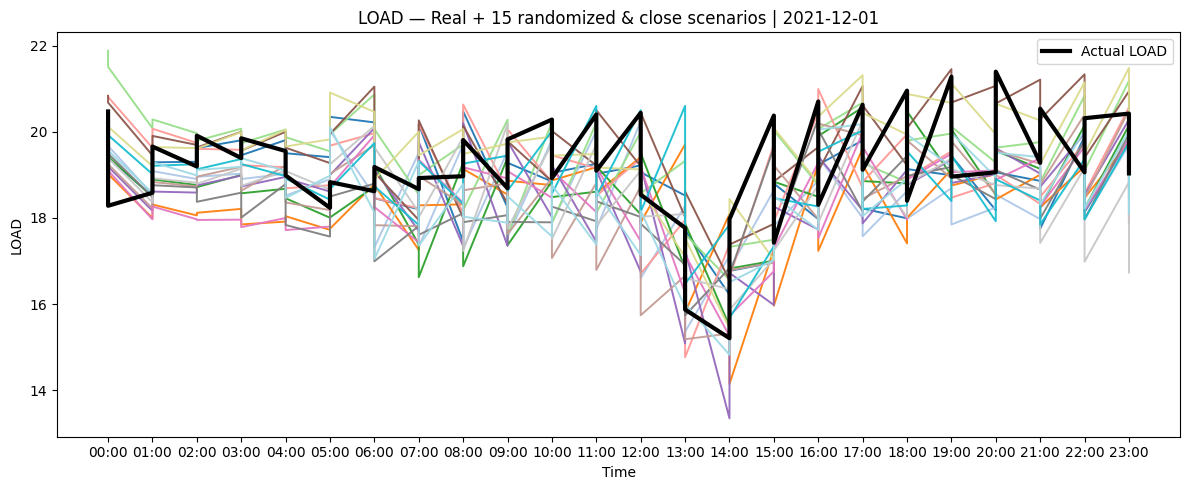

✅ Saved: outputs_randomized15/LOAD_randomized_top15_2021-12-01.png


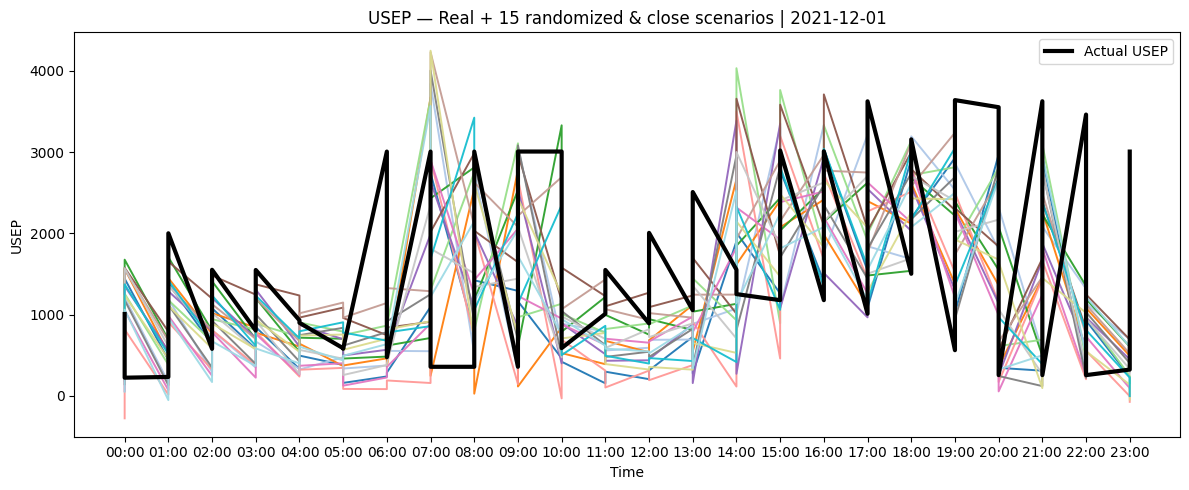

✅ Saved: outputs_randomized15/USEP_randomized_top15_2021-12-01.png
[stats] avg MAE — LOAD: 1.109, USEP: 1066.273


{'date': '2021-12-01',
 'load_png': 'outputs_randomized15/LOAD_randomized_top15_2021-12-01.png',
 'usep_png': 'outputs_randomized15/USEP_randomized_top15_2021-12-01.png',
 'outdir': 'outputs_randomized15'}

In [ ]:
from forecast_randomized import plot_two_graphs_for_date_randomized

plot_two_graphs_for_date_randomized(
    "2021-12-01",
    n_scenarios=2200,
    z_std=0.35,
    residual_temp=1.15,
    gp_len=6.0, gp_scale=0.28,
    warp_strength=0.12,
    dropout_p=0.12,
    close_quantile=0.50,
    top_k=15
)